<a href="https://colab.research.google.com/github/mz1119/shaker-level-detection-model/blob/main/Applying_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive, allows access to folder in google drive
#for this project, i made a folder in my drive called Blue Hill and worked out of that folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
from random import randrange

In [ ]:
import pandas as pd
#get json with file names, json created using VGG image annotator, uploaded to Blue Hill drive folder
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill/via_project_13Jun2021_18h22m_json.json')
data_frame = data_frame.transpose().reset_index()[['filename','regions']]

In [ ]:
#load models, these models were saved to my Blue Hill folder in drive using two other colab notebooks, Outline_Mask_Model and Level_Mask_Model
outline_model = torch.load("/content/drive/My Drive/Blue Hill/Saved_Outline_Mask_Model.pth")
level_model = torch.load("/content/drive/My Drive/Blue Hill/Saved_Level_Mask_Model.pth")

cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


difference: 88.34317111533562


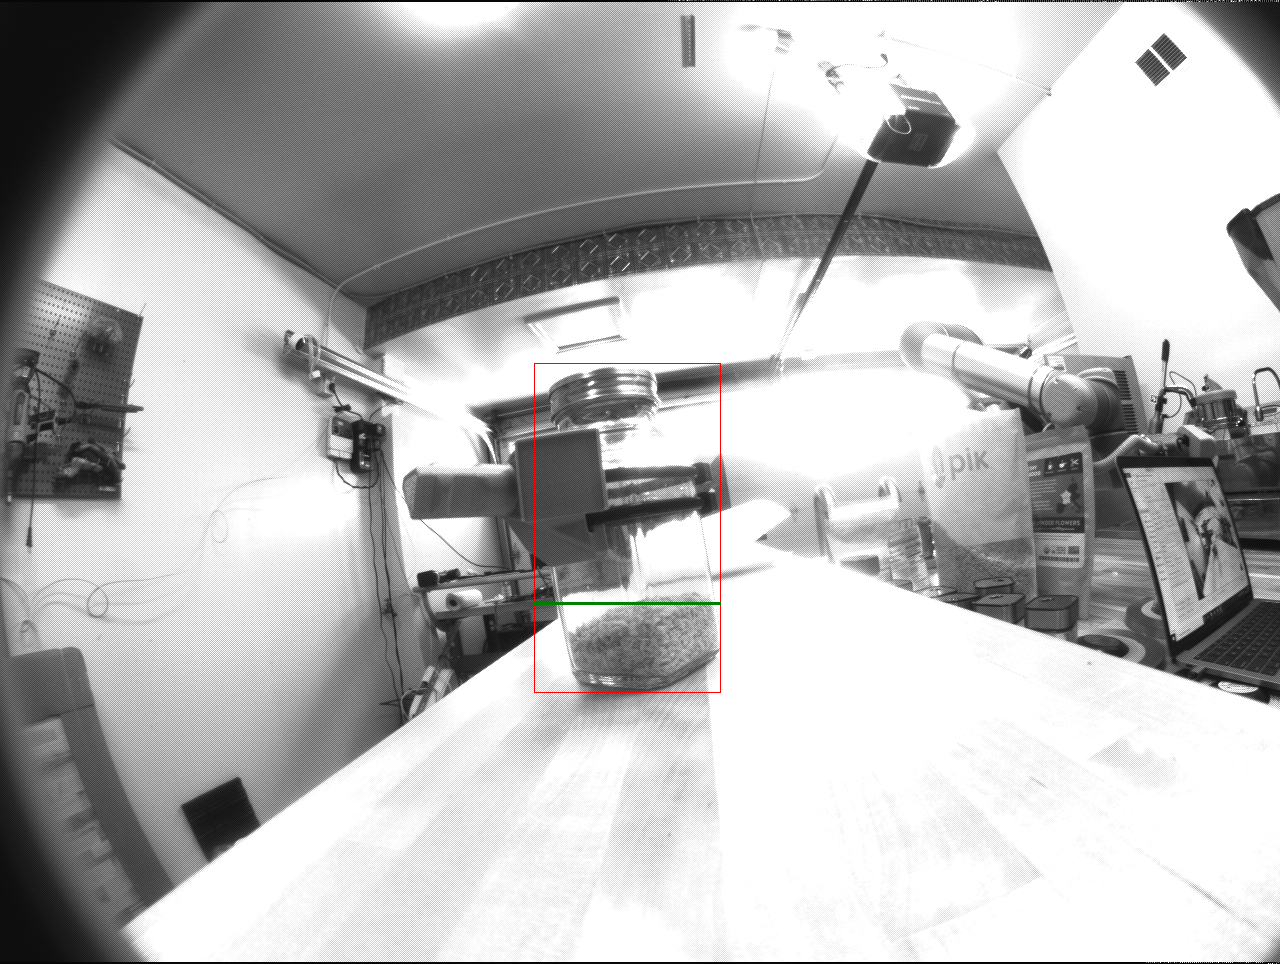

In [ ]:
#get device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

#select and open random image from json
row = randrange(data_frame.shape[0])
file_name = data_frame['filename'][row]
img = Image.open("/content/drive/My Drive/Blue Hill/Coffee_Shaker_Images/" + file_name).convert("RGB")

#get image
test_img = img

#convert img to tensor
PIL_to_tensor = transforms.Compose([
        transforms.ToTensor()
        ])
img = PIL_to_tensor(img)

#get predictions from both models of this image
level_model.eval() #puts model in eval mode
with torch.no_grad():
    level_prediction = level_model([img.to(device)])

outline_model.eval()
with torch.no_grad():
    outline_prediction = outline_model([img.to(device)])

#gets weighted average of y values in mask, with weight depending on pixel value from 0-255
mask_array = level_prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
sum = 0
non_zero_pixels = 0
for i in range(len(mask_array)):
    for j in range(len(mask_array[i])):
        if mask_array[i][j] != 0:
            non_zero_pixels += mask_array[i][j]
            sum += mask_array[i][j]*i
y_value = sum/non_zero_pixels


#this section of code overlays the mask over the image itself
# mask_img = Image.fromarray(level_prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
# #make black pixels on mask transparent
# mask_img = mask_img.convert("RGBA")
# datas = mask_img.getdata()
# newData = []
# for item in datas:
#     if item[0] == 0 and item[1] == 0 and item[2] == 0:
#         newData.append((255, 255, 255, 0))
#     elif item[0] == item[1] == item[2]:
#         x = item[0]
#         newData.append((x, 0, 0, 255))
#     else:
#         newData.append(item)
# mask_img.putdata(newData)
# #overlay partial transparent mask_img over test_img
# test_img.paste(mask_img, (0, 0), mask_img)


#get shape of bounding box
shape = []
for counter in range(outline_prediction[0]['boxes'][0].size()[0]):
  shape.append(outline_prediction[0]['boxes'][0][counter].item())

#draw bounding box
imgdraw = ImageDraw.Draw(test_img) 
imgdraw.rectangle(shape, fill = None, outline ="red")
imgdraw.line([(shape[0],y_value),(shape[2],y_value)], fill = 'green', width = 3)

#difference between average y_value of mask and bottom of bounding box
difference = shape[3] - y_value
print("difference: " + str(difference))

test_img